# Dataset 1: articles_dataset.csv

#### a. Import required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
#import library
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

from ds_utils.clustering import vectorize, mbkmeans_clusters
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### b. Data Preprocessing

In [3]:
import pandas as pd
df = pd.read_csv("./drive/MyDrive/STBI/Proyek/Dataset/articles_data.csv")
df.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(10437, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10435 non-null  object 
 5   description                      10413 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          9145 non-null   object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

In [6]:
# drop atribut 
df = df.drop(['Unnamed: 0', 'source_id', 'title', 'description', 'source_name', 'author', 'url', 'url_to_image', 'published_at', 'top_article', 'engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count', 'engagement_comment_plugin_count'], axis = 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  9145 non-null   object
dtypes: object(1)
memory usage: 81.7+ KB


In [8]:
# Checking duplicate value
print(str(df.describe(include=object)))

                                                  content
count                                                9145
unique                                               8385
top     Chat with us in Facebook Messenger. Find out w...
freq                                                  125


In [9]:
# remove duplicate value (text) in contenct attribute
df.drop_duplicates(subset=['content'], keep='last')

,content
1,The States jobless rate fell to 5.2 per cent l...
2,Louise Kennedy is showing off her autumn-winte...
3,"Han Kwang Song, the first North Korean footbal..."
5,"""This Tender Land: a Novel"" (Atria Books), by ..."
6,LONDON (Reuters) - The European Union is waiti...
...,...
10429,For his latest installation of the SCAR Projec...
10431,There are numerous bargains waiting to be pick...
10432,Growth in the U.S. economys vast services sect...
10433,ZURICH/HONG KONG (Reuters) - The announcement ...


In [10]:
# Checking null value in attribute 
df.isna().sum()

content    1292
dtype: int64

In [11]:
#drop null value
df = df.dropna()


In [12]:
df

,content
0,WASHINGTON (Reuters) - The National Transporta...
1,The States jobless rate fell to 5.2 per cent l...
2,Louise Kennedy is showing off her autumn-winte...
3,"Han Kwang Song, the first North Korean footbal..."
5,"""This Tender Land: a Novel"" (Atria Books), by ..."
...,...
10428,"Just last week, the Disney Magic arrived to Ne..."
10429,For his latest installation of the SCAR Projec...
10431,There are numerous bargains waiting to be pick...
10432,Growth in the U.S. economys vast services sect...


In [ ]:
#saving the result
df.to_csv("./drive/MyDrive/STBI/Proyek/Dataset/clean_articles_data_word2vec.csv", index=True)

#### C. Text Preprocessing

In [13]:
# remove number
def remove_number(text):
    return  re.sub(r"\[0-9]+", "", str(text))
 
df = df['content'].apply(remove_number)

In [14]:
# remove punctuation
def punctuation(txt):
  return re.sub(r"[^\w\s]","", str(txt))

df = df.apply(punctuation)

In [15]:
import nltk
nltk.download('punkt')
# tokenization
def word_tokenize_wrapper(text):
  return word_tokenize(text)
df = df.apply(word_tokenize_wrapper)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
#stopword removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
print(sw_nltk)
def stopword(text):
  words = [word for word in text if word.lower() not in sw_nltk]
  return words
df = df.apply(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [17]:
#normalization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
def lemma(text):
  lemmatizer = WordNetLemmatizer()
  Output= [lemmatizer.lemmatize(words_sent) for words_sent in text]
  return Output
df = df.apply(lemma)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#saving the rusult
df.to_csv("./drive/MyDrive/STBI/Proyek/Dataset/prepro_articles_data_word2vec.csv", index=True)

#### D. Word Embeding Using Word2Vec

In [18]:
# vocabulary
docs = df.values
tokenized_docs = df.values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

len(vocab)

35843

In [19]:
vocab.most_common(10)

[('char', 8773),
 ('said', 1712),
 ('Reuters', 1309),
 ('year', 1099),
 ('US', 1090),
 ('new', 824),
 ('say', 734),
 ('Thursday', 711),
 ('President', 702),
 ('one', 646)]

In [20]:
#word embedding with word2vec
model1 = Word2Vec(sentences=tokenized_docs, workers=1, seed=42)

In [21]:
# test model
model1.wv.most_similar("moon", topn=5)

[('different', 0.999763011932373),
 ('thats', 0.9997302293777466),
 ('massive', 0.9997126460075378),
 ('sometimes', 0.9997038841247559),
 ('product', 0.9996679425239563)]

In [22]:
vectorized_docs = vectorize(df, model = model1, strategy="average")
len(vectorized_docs), len(vectorized_docs[0])

(9145, 100)

#### E. Generate and analyze clusters

In [26]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [27]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=50, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 50
Silhouette coefficient: 0.17
Inertia:414.6398246826995
Silhouette values:
    Cluster 2: Size:125 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 4: Size:89 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 23: Size:38 | Avg:0.39 | Min:-0.36 | Max: 0.68
    Cluster 7: Size:146 | Avg:0.37 | Min:-0.03 | Max: 0.57
    Cluster 6: Size:194 | Avg:0.37 | Min:0.02 | Max: 0.57
    Cluster 12: Size:97 | Avg:0.31 | Min:-0.07 | Max: 0.53
    Cluster 47: Size:146 | Avg:0.28 | Min:-0.05 | Max: 0.50
    Cluster 3: Size:108 | Avg:0.28 | Min:-0.04 | Max: 0.50
    Cluster 8: Size:125 | Avg:0.24 | Min:0.04 | Max: 0.44
    Cluster 41: Size:64 | Avg:0.22 | Min:-0.00 | Max: 0.45
    Cluster 0: Size:82 | Avg:0.22 | Min:-0.02 | Max: 0.47
    Cluster 18: Size:40 | Avg:0.22 | Min:-0.13 | Max: 0.47
    Cluster 26: Size:144 | Avg:0.22 | Min:-0.11 | Max: 0.46
    Cluster 46: Size:123 | Avg:0.21 | Min:-0.12 | Max: 0.43
    Cluster 15: Size:88 | Avg:0.21 | Min:-0.11 | Max: 0.46
    Cluster 30: Size:118

In [29]:
print("Top terms per cluster (based on centroids):")
for i in range(50):
    tokens_per_cluster = ""
    most_representative = model1.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: Japan win semifinal warmup Walt 
Cluster 1: rule adding Press visit tax 
Cluster 2: whats happening Messenger Find Chat 
Cluster 3: inquiry adviser Jimmy Erdogan Mike 
Cluster 4: minute BBC Service five World 
Cluster 5: store hour almost count loss 
Cluster 6: patient land finally sea nothing 
Cluster 7: Agriculture Paschal Mohammad defy Finance 
Cluster 8: Photo Police PC Media High 
Cluster 9: significant scheduled nothing history open 
Cluster 10: party delay Dáil longawaited legal 
Cluster 11: third record well thing fall 
Cluster 12: Washington investigate president Bolton presidency 
Cluster 13: High Plans Liberal Getty Scottish 
Cluster 14: Ukraine tweeted Afghanistan whistleblower resort 
Cluster 15: Mellon bourse City Governor stripped 
Cluster 16: expected reduce Walmart due planned 
Cluster 17: little dating difficult content notorious 
Cluster 18: impeachment inquiry Putin Pences Pompeo 
Cluster 19: qualifying 5 quarte

In [30]:
test_cluster = 48
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

['Walmart', 'Inc', 'said', 'stop', 'selling', 'ammunition', 'assaultstyle', 'rifle', 'handgun', 'restricting', 'retailer', 'gunrelated', 'sale', 'policy', 'two', 'deadly', 'shooting', 'Walmart', 'store', 'last', 'month', 'Ammunition', 'used', 'highcapacity', '254', 'char']
-------------
['Virgin', 'Galactic', 'say', 'contracted', 'Italian', 'air', 'force', 'suborbital', 'research', 'flight', 'aboard', 'winged', 'rocket', 'ship', 'company', 'announced', 'Wednesday', 'mission', 'flown', 'early', 'next', 'year', 'carrying', 'three', 'Italian', 'specialist', '492', 'char']
-------------
['North', 'Korea', 'fired', 'may', 'submarinelaunched', 'ballistic', 'missile', 'SLBM', 'Wednesday', 'would', 'first', 'test', 'three', 'year', 'relatively', 'young', 'rapidly', 'progressing', 'programme', 'deliver', 'nuclear', 'weapon', 'launch', 'come', 'hour', 'af', '4742', 'char']
-------------
['Walmart', 'Tuesday', 'said', 'ban', 'shopper', 'openly', 'carrying', 'gun', 'store', 'end', 'sale', 'ammunit

#### F. TF-IDF

In [33]:
# untuk tf-idf
import pandas as pd
data = pd.read_csv("./drive/MyDrive/STBI/Proyek/Dataset/articles_data.csv")
data.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df):
    tfidf = TfidfVectorizer( stop_words='english',use_idf=True)
    tfidf_matrix = tfidf.fit_transform(df)
    return tfidf_matrix

In [35]:
# Let's create a matrix with tfidf for the column abstract
tfidf_matrix = tfidf(data['content'].values.astype('U'))

In [36]:
# in order to explore which documents have more similar respresentaiton, consine simliartiy can be used
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf_matrix[0:1], tfidf_matrix).flatten()

# 10 most related documents indices
related_docs_indices = cosine_similarities.argsort()[:-11:-1]
print("Related Document:",related_docs_indices)

# Cosine Similarties of related documents
print("Cosine Similarites of related documents",cosine_similarities[related_docs_indices])

Related Document: [    0   143   490  1152  9923 10338  9266  8975  9825  6624]
Cosine Similarites of related documents [1.         1.         0.85994523 0.41752305 0.28955808 0.28955808
 0.25402214 0.21863433 0.19385649 0.18572314]


In [37]:
# Let's take a look at two most similar document
data.iloc[0]['content']

'WASHINGTON (Reuters) - The National Transportation Safety Board said Tuesday a Tesla Model S was in Autopilot mode when it struck a fire truck in Culver City, California one of a series of crashes the board is investigating involving Tesla’s driver assistance… [+478 chars]'

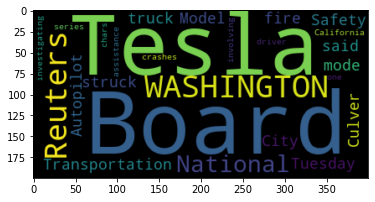

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate(data.iloc[0]['content'])
plt.imshow(wordcloud, interpolation="bilinear")